In [63]:
import pandas as pd
import math
import random
import warnings

class dataLoader:
    def __init__(self, data_url, label):
        warnings.filterwarnings('ignore')
        pd.options.mode.chained_assignment = None
        if data_url.endswith('.csv'):
            self.data = pd.read_csv(data_url)
        elif data_url.endswith('.xlsx'):
            self.data = pd.read_excel(data_url)
        else:
            raise ValueError("Unsupported file format. Please provide a CSV or XLSX file.")
        
        self.label = label
        
        if self.label not in self.data.columns.tolist():
            raise Exception("label not in dataset")
        
    def detachedData(self, data):

        Y = data[self.label]

        X = data.drop(columns=[self.label])

        return X,Y

    def hold_out(self, train_per = 0.7, val_per = 0.3):        
        m = len(self.data)
        
        self.train_data = self.data.iloc[0: math.floor(train_per * m)] # 0-105 => 106 pt
            
        self.val_data = self.data.iloc[len(self.train_data) :]
        
        self.train_data.X, self.train_data.Y = self.detachedData(self.train_data)
        
        self.val_data.X, self.val_data.Y = self.detachedData(self.val_data)
        
    def kfold_split(self, K, shuffle=True, random_state=42):
        if shuffle:            
            indices = list(self.data.index)
            random.seed(random_state)
            random.shuffle(indices)
            self.data = self.data.iloc[indices].reset_index(drop=True)
            # chưa hiểu cách chạy self.data.iloc[indices].reset_index(drop=True)

        fold_sizes = np.full(K, len(self.data) // K, dtype=int)
        fold_sizes[: len(self.data) % K] += 1

        current = 0
        folds = []
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            folds.append(self.data.iloc[start:stop])
            current = stop

        return folds
    
    def K_fold(self, K = 5):
        folds = self.kfold_split(K, shuffle=True)  # Tách từng fold cho K

        self.val_data = []
        self.train_data = []

        for i in range(K):
            self.val_data.append(folds[i])  # Chọn fold[i] làm tập validation

            train_j = pd.DataFrame()  # Khởi tạo lại tập huấn luyện trong mỗi vòng lặp
            for j in range(K):
                if i != j:
                    train_j = pd.concat([train_j, folds[j]], axis=0, ignore_index=True)
            self.train_data.append(train_j)  # Thêm train_j vào self.train_data

        for i in range(len(self.train_data)):
            self.train_data[i].X, self.train_data[i].Y = self.detachedData(self.train_data[i])
            
            self.val_data[i].X, self.val_data[i].Y = self.detachedData(self.val_data[i])
            
    def LOO(self):
        self.K_fold(len(self.data))
        

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class Evaluate:
    @staticmethod
    def loss(y_true, y_pred):
        return abs(y_true - y_pred) / len(y_true)
    
    @staticmethod
    def confusion_matrix(y_true, y_pred):
        unique_labels = np.unique(y_true)
        matrix = {label: {l: 0 for l in unique_labels} for label in unique_labels}

        for true, pred in zip(y_true, y_pred):
            matrix[true][pred] += 1

        # Convert to DataFrame
        matrix_df = pd.DataFrame(matrix).T.fillna(0)
        
        return matrix_df

    @staticmethod
    def classification_report(y_true, y_pred):
        cm = Evaluate.confusion_matrix(y_true, y_pred)
        report = {}
        
        for label in cm.index:
            TP = cm.loc[label, label]
            FP = cm[label].sum() - TP
            FN = cm.loc[label].sum() - TP
            TN = cm.sum().sum() - (TP + FP + FN)
            
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
            tpr = recall  # True Positive Rate is the same as Recall
            
            report[label] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1_score,
                'fpr': fpr,
                'tpr': tpr
            }

        # Plot the heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=cm.columns, yticklabels=cm.index)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        return report

In [65]:
import numpy as np
import matplotlib.pyplot as plt

class LDA:
    def __init__(self):
        self.mean_class = {}
        self.cov_class = {}
        self.optimal_projections = None
        self.mean_lin_diss = {}

    def fit(self, X_train, Y_train):
        # Lấy các lớp duy nhất và số lớp
        classes = np.unique(Y_train)
        num_classes = len(classes)
        
        # Khởi tạo ma trận scatter trong lớp W và tổng số hàng
        W = np.zeros((X_train.shape[1], X_train.shape[1]))
        sum_row = 0

        # Tính mean và covariance cho từng lớp
        for cls in classes:
            # Lấy chỉ số nơi Y_train bằng cls
            class_samples = X_train[Y_train[:, 0] == cls]
            
            self.mean_class[cls] = np.mean(class_samples, axis=0)
            self.cov_class[cls] = np.cov(class_samples, rowvar=False)
            
            row_in_cls = class_samples.shape[0]
            W += (row_in_cls - 1) * self.cov_class[cls]
            sum_row += row_in_cls

        # Tính ma trận scatter trong lớp (W)
        W = W / (sum_row - num_classes)
    
        # Tính ma trận scatter tổng (T)
        T = np.cov(X_train, rowvar=False)

        # Tính ma trận scatter giữa lớp (B)
        B = T - W

        # Tính ma trận tối ưu S
        S = np.dot(np.linalg.inv(W), B)

        # Tìm giá trị riêng và vector riêng
        eig_vals, eig_vecs = np.linalg.eig(S)
        
        # Sắp xếp các giá trị riêng và vector riêng theo thứ tự giảm dần
        idx = np.argsort(eig_vals)[::-1]
        eig_vals = eig_vals[idx]
        eig_vecs = eig_vecs[:, idx]
        
        # Lưu trữ vector riêng tối ưu (tương ứng với giá trị riêng lớn nhất)
        self.optimal_projections = eig_vecs[:, :1]
        
        # Tính trung bình khoảng cách tuyến tính cho từng lớp
        for cls in classes:
            # Chiếu dữ liệu vào không gian tối ưu
            proj_X_cls = np.dot(X_train[Y_train[:, 0] == cls], self.optimal_projections)
            # Tính giá trị trung bình của các vector đã chiếu
            mean_lin_dis = np.mean(proj_X_cls, axis=0)
            self.mean_lin_diss[cls] = mean_lin_dis
            
        # Sắp xếp các lớp dựa trên giá trị trung bình của các vector đã chiếu
        sorted_items = sorted(self.mean_lin_diss.items(), key=lambda x: np.mean(x[1]))
        
        # In ra các giá trị trung bình đã sắp xếp
        for item in sorted_items:
            print(f"Class {item[0]} - Mean Linear Dissimilarity: {np.mean(item[1])}")
        
        # Tính và in ra ngưỡng cắt giữa các lớp
        self.cutoff_values = []
        print()
        for i in range(len(sorted_items) - 1):
            cutoff_value = (np.mean(sorted_items[i][1]) + np.mean(sorted_items[i + 1][1])) / 2
            self.cutoff_values.append(cutoff_value)
            print(f"Cutoff between Class {sorted_items[i][0]} and Class {sorted_items[i + 1][0]}: {cutoff_value}")

        return sorted_items, self.cutoff_values
    
    def predict(self, X_val):
        # Kiểm tra xem đã fit mô hình chưa
        if self.optimal_projections is None:
            raise ValueError("Model has not been fitted yet. Please call fit() first.")

        # Chiếu dữ liệu vào không gian tối ưu
        proj_X_val = np.dot(X_val, self.optimal_projections)

        # Dự đoán dựa trên ngưỡng cắt
        predictions = np.zeros(len(X_val), dtype=int)
        for i in range(len(proj_X_val)):
            for j in range(len(self.cutoff_values)):
                if np.mean(proj_X_val[i, :]) < self.cutoff_values[j]:
                    predictions[i] = j
                    break
                if j == len(self.cutoff_values) - 1:
                    predictions[i] = j + 1
        
        return predictions


Class 0 - Mean Linear Dissimilarity: 40.71053048075242
Class 1 - Mean Linear Dissimilarity: 45.53171867921744

Cutoff between Class 0 and Class 1: 43.12112457998493
    Y_acutal  Y_predict
0          0          0
1          0          0
2          0          0
3          0          0
4          0          0
5          0          0
6          1          1
7          1          1
8          1          1
9          1          1
10         1          1
11         1          1


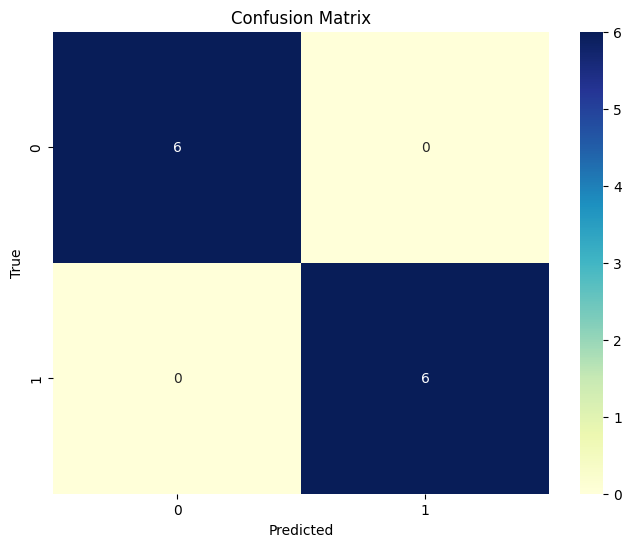

Classification Report:
Class 0:
  precision: 1.00
  recall: 1.00
  f1_score: 1.00
  fpr: 0.00
  tpr: 1.00
Class 1:
  precision: 1.00
  recall: 1.00
  f1_score: 1.00
  fpr: 0.00
  tpr: 1.00


In [89]:
import numpy as np
# Dữ liệu mẫu với nhiều đặc trưng hơn
df = dataLoader('/kaggle/input/team2-dataset/team2_dataset/chap4.xlsx','INFECTION')
X, Y = df.detachedData(df.data)
X = X.values
Y = Y.values
Y_reshape = Y.reshape(len(X), 1)

# Khởi tạo và huấn luyện mô hình
lda = LDA()
sorted_mean_lin_diss, cutoff_values = lda.fit(X, Y_reshape)
# Dự đoán và vẽ biểu đồ quyết định LDA
predictions = lda.predict(X)

data_rs2show = {'Y_acutal': Y, 'Y_predict': predictions}

rs2show = pd.DataFrame(data_rs2show)
print(rs2show)

report = Evaluate.classification_report(Y.flatten(), predictions)
print("Classification Report:")
for label, metrics in report.items():
    print(f"Class {label}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")